# CSCI2000U - Final Project


## Introduction

We chose this dataset pulled off of Kaggle because it pertains to movies and tv series, which everyone in the group is familiar with, and also has an interest in. Going through other datasets, we were often disappointed either by the lack of data, or the range of categories that are covered within the dataset. This dataset was able to do what we needed: have lots of data we can parse, and have lots of columns we can work with.

We initially looked at using sets such a Utility Cut permits or chemical tracking data for the city of Toronto, but they either didn't have enough data to reasonably work with or weren't interesting to everyone in the group.

Due to this, we decided to go with the IMDB's most popular films and series set.



### These are the list of questions we wish to answer, and expand upon in our analysis:
   - How does the amount of episodes in a tv show effect the ratings? For shows with a greater amount of episodes,
        are the average rating worse, or better than shows with fewer?
   - What are considered popular genres over the years? Do the ratings correlate? 
   - What impact does mature content make on the ratings of movies/shows the most?
   - Do TV series or movies perform better? Based on the year of publish, does this make an impact or change the ratings?
   - ADDITIONAL QUESTION GOES HERE

### Members and contributions:

Ashar Izhar ->

Bridget Green ->

Cameron Millar ->

Julian Finley -> 


## Description of Data

The IMDB's most popular film and series dataset is a list described by its name. In this dataset we can see a range of movies and films from the early 20th century to the current year, with information about the movie such as duration, genre, number of episodes, as well as user engagement information such as ratings and votes. All these datapoints can prove to be useful when diving into the analysis of said data.

The data was collected by the dataset creator using web scraping directly from the IMDB website, and then compiled within a csv file for ease of use.

Full credits go towards the compiler of the dataset; Mazen Ramadan, with a link to the set itself: https://www.kaggle.com/mazenramadan/imdb-most-popular-films-and-series

Information from this dataset was retrieved from the original source: https://www.imdb.com/


## Analysis of the data

The data is organized in such a manner thatis easy to identify their use case and how they can be manipulated. Below is the list of columns within the dataset, and their description:

    Name: The title of the film or tv series
    Date: The date by year
    Rate: The IMDB rating given for the title
    Votes: The number of user votes which have contributed the the votes column
    Genre: The genre(s) of the film or tv series. Multiple can be listed per title
    Duration: The running length in minutes for the film or tv series per episode.
    Type: The indicator on whether this is a film or tv series
    Certificate: The audiance and/or age rating for the title(TV-Y, PG, PG-13, etc)
    Episodes: If this is a tv series, the number of episodes present is recorded
    Adult oriented content present(from mild, moderate, severe):
        -Nudity
        -Violence
        -Profanity
        -Alcohol
        -Frightening
      
The data quality holds up, and any missing data present is due to it either being non-existant(i.e., no adult content being in an all ages movie), or no votes/ratings(no user engagement with the film or tv series).

Data that would be prudent to double check for integrity and cleaning would be:
    
    -Completely empty columns
    -Missing or non-numerical dates
    -Removal of 'No Rates' when doing analysis on the ratings column 
    -Removal of 'No Votes' when doing analysis on the votes column
    -If the genre column has more than one genre, make sure all are taken into account for their appropriate use cases.
    -Removal of 'None' when doing analysis on the duration column
    -When doing analysis on the type column, specify directly which will be worked with
    -Remove all non-numerical from episode column if working with tv series
    -When working will adult content, remove 'No Rate' entries

## Exploratory Data Analysis

In [1]:
#Given a csv file format, we must make it usable by pandas in order to make it a dataframe

import csv
import re
from functools import reduce
import numpy as np
import pandas as pd
import json
pd.options.mode.chained_assignment = None  # default='warn'

def get_data_csv():
    collection = []
    with open('imdb.csv', 'r') as f:
        for line in csv.DictReader(f):
            collection.append(line)
        return collection
        
# the data    
data = get_data_csv()
df = pd.DataFrame(data)

### Basic Analysis of the data

In [2]:
#Date Range
maxYear = max(data, key=lambda item:item['Date'])
minYear = min(data, key=lambda item:item['Date'])
print ("Range in years:", (minYear['Date']), "-", (maxYear['Date']))

#Number of records
print("# of data records:", len (data))

#Unique genres by length
uniqueGenres = set(item['Genre'] for item in data)
print("# of unique genres: ", len(uniqueGenres))

#Unique titles by type
uniqueFilms = list(filter(lambda item: 'Film' in item['Type'], data))
uniqueSeries = list(filter(lambda item: 'Series' in item['Type'], data))
print("# of unique movies: ", len(uniqueFilms))
print("# of unique shows: ", len(uniqueSeries))

#Unique ratings by length
uniqueRatings = set(item['Rate'] for item in data)
print("# of unique ratings: ", len(uniqueRatings))

#Top 3 records
print("Top 3 records:", json.dumps(data[:3],indent=4),'\n')

Range in years: 1922 - 2023
# of data records: 6178
# of unique genres:  377
# of unique movies:  4446
# of unique shows:  1732
# of unique ratings:  77
Top 3 records: [
    {
        "Name": "No Time to Die",
        "Date": "2021",
        "Rate": "7.6",
        "Votes": "107,163",
        "Genre": "Action, Adventure, Thriller",
        "Duration": "163 ",
        "Type": "Film",
        "Certificate": "PG-13",
        "Episodes": "-",
        "Nudity": "Mild",
        "Violence": "Moderate",
        "Profanity": "Mild",
        "Alcohol": "Mild",
        "Frightening": "Moderate"
    },
    {
        "Name": "The Guilty",
        "Date": "2021",
        "Rate": "6.3",
        "Votes": "64,375",
        "Genre": "Crime, Drama, Thriller",
        "Duration": "90 ",
        "Type": "Film",
        "Certificate": "R",
        "Episodes": "-",
        "Nudity": "None",
        "Violence": "None",
        "Profanity": "Severe",
        "Alcohol": "None",
        "Frightening": "Moderate"


This summary of data just give us a small bit of understanding about what to expect when working with the data, and the details of the certain ranges and parameters to help in future analysis calculations.

We see that the range of films is from the early 20th century to a couple years into the future; which means there are surely some currently unwatchable programs on the list.
Additionally as a movie database, it makes sense that there are more films present than tv series, at nearly double the count.

### Answering our questions about the dataset

#### How does the amount of episodes in a tv show effect the ratings? For shows with a greater amount of episodes, are the average rating worse, or better than shows with fewer?

In [8]:
#First we drop the duplicates in the dataframe. After analysis, it was discovered there was over 1000 duplicate entries
#in the dataset, which could have surely skewed results.
df = df.drop_duplicates()

#Since we are looking at the 'Rate' and 'Type' column specifically for this question, we should clean the column of 
#missing ratings, and then isolute for 'Series' only
newDfSeries = df[df['Rate'] != 'No Rate']
newDfSeries = newDfSeries.loc[newDfSeries['Type'] == 'Series']

#For displaying various charts, it's a good idea to set the types of the entries to something readable by pd plot
newDfSeries['Episodes'] = newDfSeries['Episodes'].astype(int)
newDfSeries['Rate'] = newDfSeries['Rate'].astype(float)
newDfSeries['Date'] = newDfSeries['Date'].astype(int)

#Lastly sort by episode count, since this is the most important metric for analysis
newDfSeries = newDfSeries.sort_values(by=['Episodes'], ascending=False)
newDfSeries

,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
2075,Days of Our Lives,2021,5.1,"6,506","Drama, Romance",60,Series,TV-14,14301,Moderate,Mild,Mild,Moderate,Mild
2514,The Young and the Restless,2021,5.1,"5,978","Drama, Romance",60,Series,TV-14,12277,Moderate,Severe,Severe,Mild,Mild
2807,Coronation Street,2020,5.6,"5,202","Drama, Romance",30,Series,TV-PG,10336,Mild,Moderate,Mild,Mild,Mild
4257,Neighbours,2014,5.4,"5,020","Drama, Romance",22,Series,TV-G,9059,Mild,Mild,Mild,Mild,Mild
2951,The Bold and the Beautiful,2015,3.4,"7,411","Drama, Romance",30,Series,TV-14,8365,Mild,Mild,Mild,Mild,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,Crime Stories: India Detectives,2021,7.4,646,"Documentary, Crime, Mystery",47,Series,TV-MA,4,No Rate,No Rate,No Rate,No Rate,No Rate
2555,LuLaRich,1956,7.8,"2,381",Documentary,None,Series,TV-14,4,No Rate,No Rate,No Rate,No Rate,No Rate
1552,Time,1990,8.3,"14,288","Crime, Drama",59,Series,None,3,No Rate,No Rate,No Rate,No Rate,No Rate
2120,The Problem with Jon Stewart,2014,7.6,443,Talk-Show,None,Series,TV-MA,3,None,Moderate,Severe,None,Severe


We can see from the head and tail of this dataframe, that the highest amount of episodes is well into the high thousands, and then have a low of 3 to 4 episodes. Just using basic reasoning we can assume the top bulk of shows will be low budget, long running series... while the bottom bulk will likely have been one-offs, or cancelled early into airing.

In [19]:
#In search of just some raw data analysis, we can find the average score of the top and bottom percentage groups. 
#In this case, we will take the top and bottom 20%, and see how the averages differ.
perc = 20
print("Amount of records in each of the top & bottom ", perc, "%: ", int(len(newDfSeries)*(perc/100)),  sep='')

#We are able to calculate the top and bottom percentage average by taking the length of the series dataframe
topPerc = newDfSeries.head(int(len(newDfSeries)*(perc/100)))
botPerc = newDfSeries.tail(int(len(newDfSeries)*(perc/100)))
print("Top ", perc, "%: ", topPerc['Rate'].astype(float).mean(), sep='')
print("Bottom ", perc, "%: ", botPerc['Rate'].astype(float).mean(), sep='')
print("Overall average rating: ", newDfSeries['Rate'].mean())

Amount of records in each of the top & bottom 20%: 282
Top 20%: 7.461347517730496
Bottom 20%: 7.104255319148937
Overall average rating:  7.549148936170212


We can see that the top 20% of series by episode count actually have an on-average higher rating than the bottom 20%. This is an interesting result, and count be for various reasons. To speculate, series that go for a long time usually only do so when proped up by fans and success factors, which would result in a higher score. On the other end, if a series is not successful or popular, it is likely to have fewer good ratings, and be cancelled early in its run.

While these speculations make sense, they do not necessarily mean they're true, and they certain do not line up with the top and bottom 5 entries... though those could also be an anomoly as well.

However, we can also see that the top and bottom 20% are outliers in their own right... as the overall average for all series is greater than both. 

<AxesSubplot:xlabel='Episodes', ylabel='Ratings'>

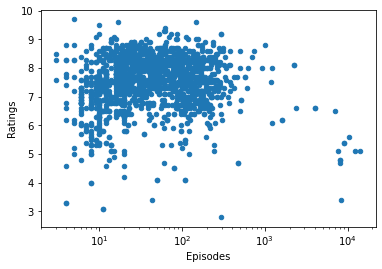

In [5]:
#Lets graph the results of the dataframe.
newDfSeries.plot(xlabel='Episodes', ylabel='Ratings', x='Episodes',y='Rate', kind='scatter', logx=True)

Since there are a lot of records, a scatter graph felt appropriate for this question. We can see that a vast majority of series have rating ranging from ~6.5 to ~8.5, which places the afformentioned overall average directly in the centre of this observation. While there are plenty of dots outside the cluster, the graph still may be hard to parse, due to the extreme amounts of episodes some series may have.

<AxesSubplot:xlabel='Episodes', ylabel='Ratings'>

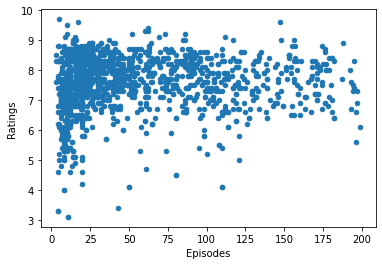

In [6]:
#To the above point, it may be appropriate to see how the average series compares to one another. Due to most series having
#an upper limit of around 200 episodes(10 seasons * 20 episodes per season), we can see how the graph looks like with these
#new limitations
newDfSeries2 = newDfSeries[~(newDfSeries['Episodes'] >= 200)]
newDfSeries2.plot(xlabel='Episodes', ylabel='Ratings', x='Episodes', y='Rate', kind='scatter')

With an upper bound defined, the distribution is much easier to identify. A lot of series are still clustered together, but we can clearly see a downwards trend of ratings and the episode count gets greater and greater for the series. The slope is fairly minor, but noticable.

To answer the question: The amount of total episodes does infact appear to affect the ratings in the long run. Once a show is able to establish itself after about 20-25 episodes,

#### What are considered popular genres over the years? Do the ratings correlate?

#### What impact does mature content make on the ratings of movies/shows the most?

#### Do TV series or movies perform better? Based on the year of publish, does this make an impact or change the ratings?

#### ADDITIONAL QUESTION GOES HERE

## Potential Data Science

## Conclusion